In [2]:
# Libraries
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report, accuracy_score


Preprocessing

In [4]:
def preprocess_image(image_path, size=(224, 224)):
    img = Image.open(image_path)
    
    # Quality enhancement
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(2.0)  # Increase sharpness
    
    # Noise reduction
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Consistency
    img = img.resize(size, Image.LANCZOS)
    
    # Normalization
    img_array = np.array(img) / 255.0
    
    # Convert back to image
    img = Image.fromarray((img_array * 255).astype(np.uint8))
    
    return img

# Apply preprocessing and save to new directory
input_dir = 'images_train_test_val/train'
output_dir = 'processed_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            preprocessed_img.save(os.path.join(output_category_path, image_name))

Train/Test Split

In [3]:
train_dir = 'processed_images'
# train_dir = 'images_train_test_val/train'
val_dir = 'images_train_test_val/validation'
test_dir = 'images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # brightness_range=[0.8, 1.2],  # Randomly adjust brightness
    # rotation_range=20,  # Randomly rotate images
    # width_shift_range=0.2,  # Randomly shift images horizontally
    # height_shift_range=0.2  # Randomly shift images vertically
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)


test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

python(18102) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Found 10500 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


Base Model Creation

In [4]:
def create_model(optimizer='adam', init_mode='uniform'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init_mode))
    model.add(Dropout(0.5))
    model.add(Dense(21, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Model Creation

In [5]:
model = create_model()
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-17 11:42:17.364431: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-07-17 11:42:17.366096: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-17 11:42:17.366752: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-17 11:42:17.367921: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-17 11:42:17.369990: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

Epoch 1/20


2024-07-17 11:42:19.470527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/165 ━━━━━━━━━━━━━━━━━━━━ 24:55 9s/step - accuracy: 0.0625 - loss: 3.1128

In [13]:
# Evaluate the model
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}, Test accuracy: {test_acc:.4f}')

165/165 ━━━━━━━━━━━━━━━━━━━━ 63s 380ms/step - accuracy: 0.5835 - loss: 1.3192
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 423ms/step - accuracy: 0.5032 - loss: 1.5427
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 420ms/step - accuracy: 0.5004 - loss: 1.5339
Train accuracy: 0.5834, Validation accuracy: 0.4886, Test accuracy: 0.5133


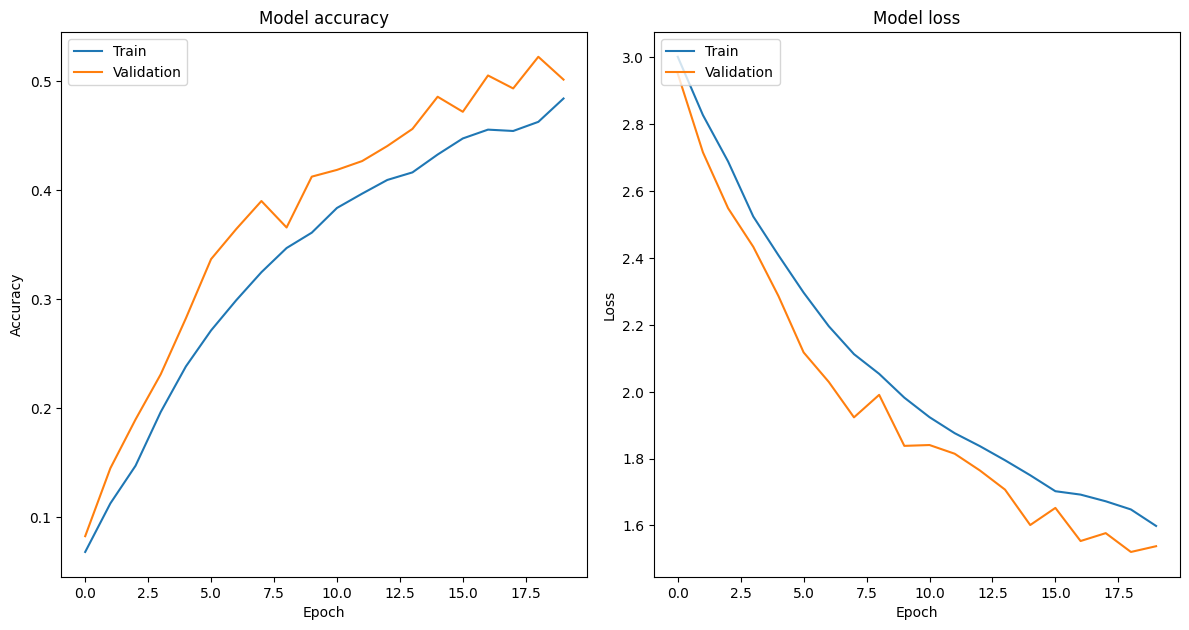

In [23]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [1]:
# Save base cnn model
model.save('base_cnn_model.h5')

NameError: name 'model' is not defined